# Word Vectorization for MetMuseum Catalogue Text

This code takes in the preprocessed exhibition catalogues as .txt files. It aggregates them into a single string text-corpus, splits it up in sentences and runs Google's Word2Vec to assign vectorial values to each word based on its usage in each found sentence.

There is as well two methods for keyword extraction from the text corpus: A frequency list (word counting) and TF-IDF. 

Down below, there are some visualization methods with matplotlib to see either all word embedings, some of them, or the clustering of particular identified terms. The 30 simmilar terms were used along with the tf-idf list to assemble a list of 100 keywords of the whole text-corpus.

In [4]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [6]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [7]:
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

In [8]:
import operator
from tabulate import tabulate
import sys
from stop_words import get_stop_words

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
book_filenames = sorted(glob.glob(r"D:\Path\to\MetBooksTxt\*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\Age_of_Spirituality_Late_Antique_and_Early_Christian_Art_Third_to_Seventh_Century_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\Al_Andalus_The_Art_of_Islamic_Spain_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\American_Art_Posters_of_the_1890s_in_The_Metropolitan_Museum_of_Art_including_the_Leonard_A_Lauder_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\American_Paradise_The_World_of_the_Hudson_River_School_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\AngloMania_Tradition_and_Transgression_in_British_Fashion_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\Art_and_Love_in_Renaissance_Italy_clean.txt',
 'D:\\ML\\Word2Vec\\MetBooksTxt\\Text_Preprocessing\\NotClean\\CleanBooks2\\Art_of_the_First_Cities_The_Thir

In [1]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "charmap") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()


### Clean corpus_raw

Removes stopwords (words which have neglegible meaning for vectorization, such as "and", "the", "a", "an") and lower-cases all text

In [24]:
stop_words = set(stopwords.words('english')) 
corpus_raw_lower = corpus_raw.lower()
corpus_raw_2 = u""

clean_corp = corpus_raw_lower.split()
for w in clean_corp :
    if w not in stop_words :
        corpus_raw_2 += w + ' ' 


*In case you need to save the complete metcorpus for editing, save the corpus_raw_lower and start from here next time*

In [159]:
text_file = open("Metcorpus.txt", "w")
text_file.write(corpus_raw_2)
text_file.close()

*Tokenize* or split into lists of sentences

In [27]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [28]:
raw_sentences = tokenizer.tokenize(corpus_raw_2)

In [30]:
#convert into a list of words
#remove unnnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [39]:
#sentence where each word is tokenized
sentences = []

for raw_sentence in raw_sentences:
    if len(raw_sentence) > 1:
        sentences.append(sentence_to_wordlist(raw_sentence))


In [40]:
sentences[:10]

[['antique',
  'early',
  'christian',
  'art',
  'third',
  'seventh',
  'century',
  'late',
  'age',
  'spirituality',
  'age',
  'spirituality',
  'edited',
  'late',
  'antique',
  'early',
  'christian',
  'art',
  'third',
  'seventh',
  'century',
  'catalogue',
  'exhibition',
  'metropolitan',
  'museum',
  'art',
  'november',
  'february',
  'kurt',
  'weitzmann',
  'metropolitan',
  'museum',
  'art',
  'new',
  'york',
  'published',
  'association',
  'princeton',
  'university',
  'press',
  'exhibition',
  'made',
  'possible',
  'grant',
  'national',
  'endowment',
  'humanities',
  'matched',
  'grant',
  'andrew',
  'w',
  'mellon',
  'foundation'],
 ['assistance',
  'received',
  'robert',
  'wood',
  'johnson',
  'jr',
  'charitable',
  'trust'],
 ['arts',
  'artifacts',
  'indemnity',
  'act',
  'indemnity',
  'granted',
  'federal',
  'council',
  'arts',
  'humanities'],
 ['jacket', 'diptych', 'christ', 'virgin', 'no'],
 ['typography',
  'peter',
  'oldenburg'

In [41]:
print(raw_sentences[2])
print(sentence_to_wordlist(raw_sentences[2]))

arts artifacts indemnity act, indemnity granted federal council arts humanities.
['arts', 'artifacts', 'indemnity', 'act', 'indemnity', 'granted', 'federal', 'council', 'arts', 'humanities']


In [42]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 4,967,961 tokens


# Keywords by Frequency list

The function names and the tabulation are weird because are coming from an online scraping tabulation procedure. Too lazy to change variable names and shorten code.

In [43]:
#clean word with regex
def clean_word(word):
    cleaned_word = re.sub('[^A-Za-z]+', '', word)
    return cleaned_word

def getWordList(url):
    word_list = []
#find the words in paragraph tag
    for text in corpus_raw:
        if text.text is None:
            continue
        #content
        content = text.text
        #lowercase and split into an array
        words = content.lower().split()

        #for each word
        for word in words:
            #remove non-chars
            cleaned_word = clean_word(word)
            #if there is still something there
            if len(cleaned_word) > 0:
                #add it to our word list
                word_list.append(cleaned_word)
                
    return word_list

def createFrquencyTable(word_list):
    #word count
    word_count = {}
    for word in word_list:
        #index is the word
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    return word_count

#remove stop words
def remove_stop_words(frequency_list):
    stop_words = get_stop_words('en')

    temp_list = []
    for key,value in frequency_list:
        if key not in stop_words:
            temp_list.append([key, value])

    return temp_list

In [44]:
toget_list = corpus_raw_lower 

In [45]:
toget_list = corpus_raw_lower 
#Take away dots, commas and split
toget_list = re.sub('\W', ' ', toget_list).split()
#Deletes short typos or any word less than 3 charachters
new_toget = [word for word in toget_list if len(word) > 2]

In [46]:
page_word_list = new_toget
#create table of word counts, dictionary
page_word_count = createFrquencyTable(page_word_list)
#sort the table by the frequency count
sorted_word_frequency_list = sorted(page_word_count.items(), key=operator.itemgetter(1), reverse=True)

In [47]:
#remove stop words if the user specified (searchmode is the function that activates when input > 2 that wrote up there)
sorted_word_frequency_list = remove_stop_words(sorted_word_frequency_list)

In [48]:
#sum the total words to calculate frequencies   
total_words_sum = 0
for key,value in sorted_word_frequency_list:
    total_words_sum = total_words_sum + value

#just get the top 30 words
if len(sorted_word_frequency_list) > 30:
    sorted_word_frequency_list = sorted_word_frequency_list[:50]
        
#create our final list which contains words, frequency (word count), percentage
final_list = []
for key,value in sorted_word_frequency_list:
    percentage_value = float(value * 100) / total_words_sum
    final_list.append([key, value, round(percentage_value, 4)])

#headers before the table
print_headers = ['Word', 'Frequency', 'Frequency Percentage']

#print the table with tabulate
print(tabulate(final_list, headers=print_headers, tablefmt='orgtbl'))


| Word         |   Frequency |   Frequency Percentage |
|--------------+-------------+------------------------|
| cat          |       23515 |                 0.5194 |
| art          |       22780 |                 0.5031 |
| fig          |       21920 |                 0.4841 |
| see          |       18415 |                 0.4067 |
| new          |       18376 |                 0.4059 |
| museum       |       17474 |                 0.3859 |
| one          |       16953 |                 0.3744 |
| century      |       16123 |                 0.3561 |
| also         |       14852 |                 0.328  |
| two          |       14327 |                 0.3164 |
| york         |       11853 |                 0.2618 |
| paris        |       10876 |                 0.2402 |
| saint        |       10446 |                 0.2307 |
| made         |        9585 |                 0.2117 |
| may          |        9452 |                 0.2088 |
| painting     |        9343 |                 0

### Come back here to look the frequency of terms we get by closeness after obtaining wordvectors

In [59]:
Termino = 'martyrdom'
print('Frequency:')
print(page_word_count[Termino])
print('Frequency percentage:')
print(float(page_word_count[Termino] * 100) / total_words_sum)

Frequency:
92
Frequency percentage:
0.032108554835827564


# Keywords by TF-IDF

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

#get the text column
stoplist = set(stopwords.words("english"))
docs = raw_sentences

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv = CountVectorizer(max_df=0.85, stop_words = stoplist)
word_count_vector = cv.fit_transform(docs)
word_count_vector.shape

(586388, 193108)

In [50]:
#This are just some words of the vocabulary, still to calculate the complete tf-idf
list(cv.vocabulary_.keys())[:10]

['antique',
 'early',
 'christian',
 'art',
 'third',
 'seventh',
 'century',
 'late',
 'age',
 'spirituality']

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [52]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [53]:
#The keyword analyzer can only extract from raw text data, so i have to apply the stopwords to the Metcorpus
stop_words = set(stopwords.words('english')) 
corpus_raw_lower = corpus_raw.lower()
corpus_raw_3 = u""

clean_corp = corpus_raw_lower.split()
for w in clean_corp :
    if w not in stop_words and len(w) >= 3 :
        corpus_raw_3 += w + ' ' 

In [54]:
if clean_corp[0] not in stop_words and len(clean_corp[0]) >= 3 :
    print(clean_corp[0])
# len(clean_corp[0])

antique


In [55]:
# you only needs to do this once
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
doc = corpus_raw_3

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,50)

print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
pp 0.229
art 0.175
cat 0.174
fig 0.165
new 0.147
see 0.145
museum 0.143
one 0.137
century 0.131
also 0.122
two 0.12
york 0.104
paris 0.098
saint 0.096
made 0.086
may 0.086
painting 0.085
early 0.081
collection 0.08
work 0.078
first 0.078
vol 0.072
portrait 0.071
van 0.07
london 0.069
left 0.067
well 0.064
figure 0.063
drawing 0.062
three 0.062
period 0.061
right 0.061
would 0.061
style 0.061
figures 0.06
drawings 0.06
works 0.059
des 0.058
artist 0.057
time 0.057
gold 0.055
many 0.055
ingres 0.055
found 0.055
arts 0.055
paintings 0.054
ca 0.054
metropolitan 0.053
design 0.053
leonardo 0.053


*It does eliminate some pesky noisy words from the list compared to frequency list, getting even more interesting results. Some words that appear only when looking for the close terms after the Word2Vec vectorization appear here as keywords, underlying their importance as possible categories to classify images.*

### Intersection between both lists

In [56]:
#TF-IDF list
tf_idf_list = keywords
# Frequency List
frequency_list=[]
for key in final_list:
    frequency_list.append([key][0][0])

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

print(intersection(tf_idf_list, frequency_list)) 


['museum', 'arts', 'cat', 'ingres', 'may', 'leonardo', 'work', 'two', 'first', 'painting', 'portrait', 'paris', 'drawing', 'figure', 'drawings', 'early', 'des', 'collection', 'time', 'one', 'metropolitan', 'new', 'works', 'london', 'period', 'artist', 'left', 'paintings', 'vol', 'century', 'style', 'see', 'saint', 'van', 'well', 'found', 'york', 'three', 'design', 'also', 'many', 'fig', 'right', 'gold', 'figures', 'made', 'art']


## Train Word2vec

In [57]:
#ONCE we have vectors
#step 3 - BUILD MODEL
#3 main tasks that vectors help with

#DISTANCE, SIMILARITY, RANKING!!!

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [58]:
Meth2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling, 
)

In [60]:
Meth2vec.build_vocab(sentences)

In [61]:
print("Word2Vec vocabulary length:", len(Meth2vec.wv.vocab))
vocab_length = len(Meth2vec.wv.vocab)

Word2Vec vocabulary length: 72707


In [62]:
Meth2vec.train(sentences,total_examples=Meth2vec.corpus_count,epochs=Meth2vec.iter )

C:\Users\juani\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(23590108, 24839805)

### Save the model

In [63]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [64]:
#os.path.join joins the current working dir with (folder in current dir, name of file)
Meth2vec.save(os.path.join("trained", "Meth2vec2020.w2v"))

## Explore the model

In [10]:
Meth2vec = w2v.Word2Vec.load(os.path.join("trained", "Meth2vec2020.w2v"))

If you wanna see the vectors uncomment below

In [2]:
# Meth2vec[['art']]

## Visualization

T-sne values extraction

In [176]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [178]:
all_word_vectors_matrix = Meth2vec.wv.vectors

In [184]:
all_word_vectors_matrix.shape

(72707, 300)

In [185]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

Saving the T-sne matrix as it takes a long time to compute, in order to pick up from here later

In [186]:
#all_word_vectors_matrix_2d
np.save('vectors_matrix.npy', all_word_vectors_matrix_2d)

#Human readable data
#np.savetxt('vectors_matrix.txt', all_word_vectors_matrix_2d)

In [187]:
all_word_vectors_matrix_2d = np.load('vectors_matrix.npy')

In [189]:
all_word_vectors_matrix_2d.shape

(72707, 2)

*Plotting*

In [190]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[Meth2vec.wv.vocab[word].index]) #all_word_vectors_matrix_2d[Meth2vec.wv.vocab.keys()]
            for word in Meth2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [191]:
#Holi aqui viendo que hace esta parte del codigo
all_word_vectors_matrix_2d[Meth2vec.wv.vocab['art'].index]

array([-24.575117,  20.499372], dtype=float32)

In [193]:
points.shape

(72707, 3)

In [194]:
points[points['word']=='art']

,word,x,y
3,art,-24.575117,20.499372


### Matplotlib plotting

Points contains all vector values. Included a library named adjustText that might break down when plotting, but is useful for having plots without overlying text

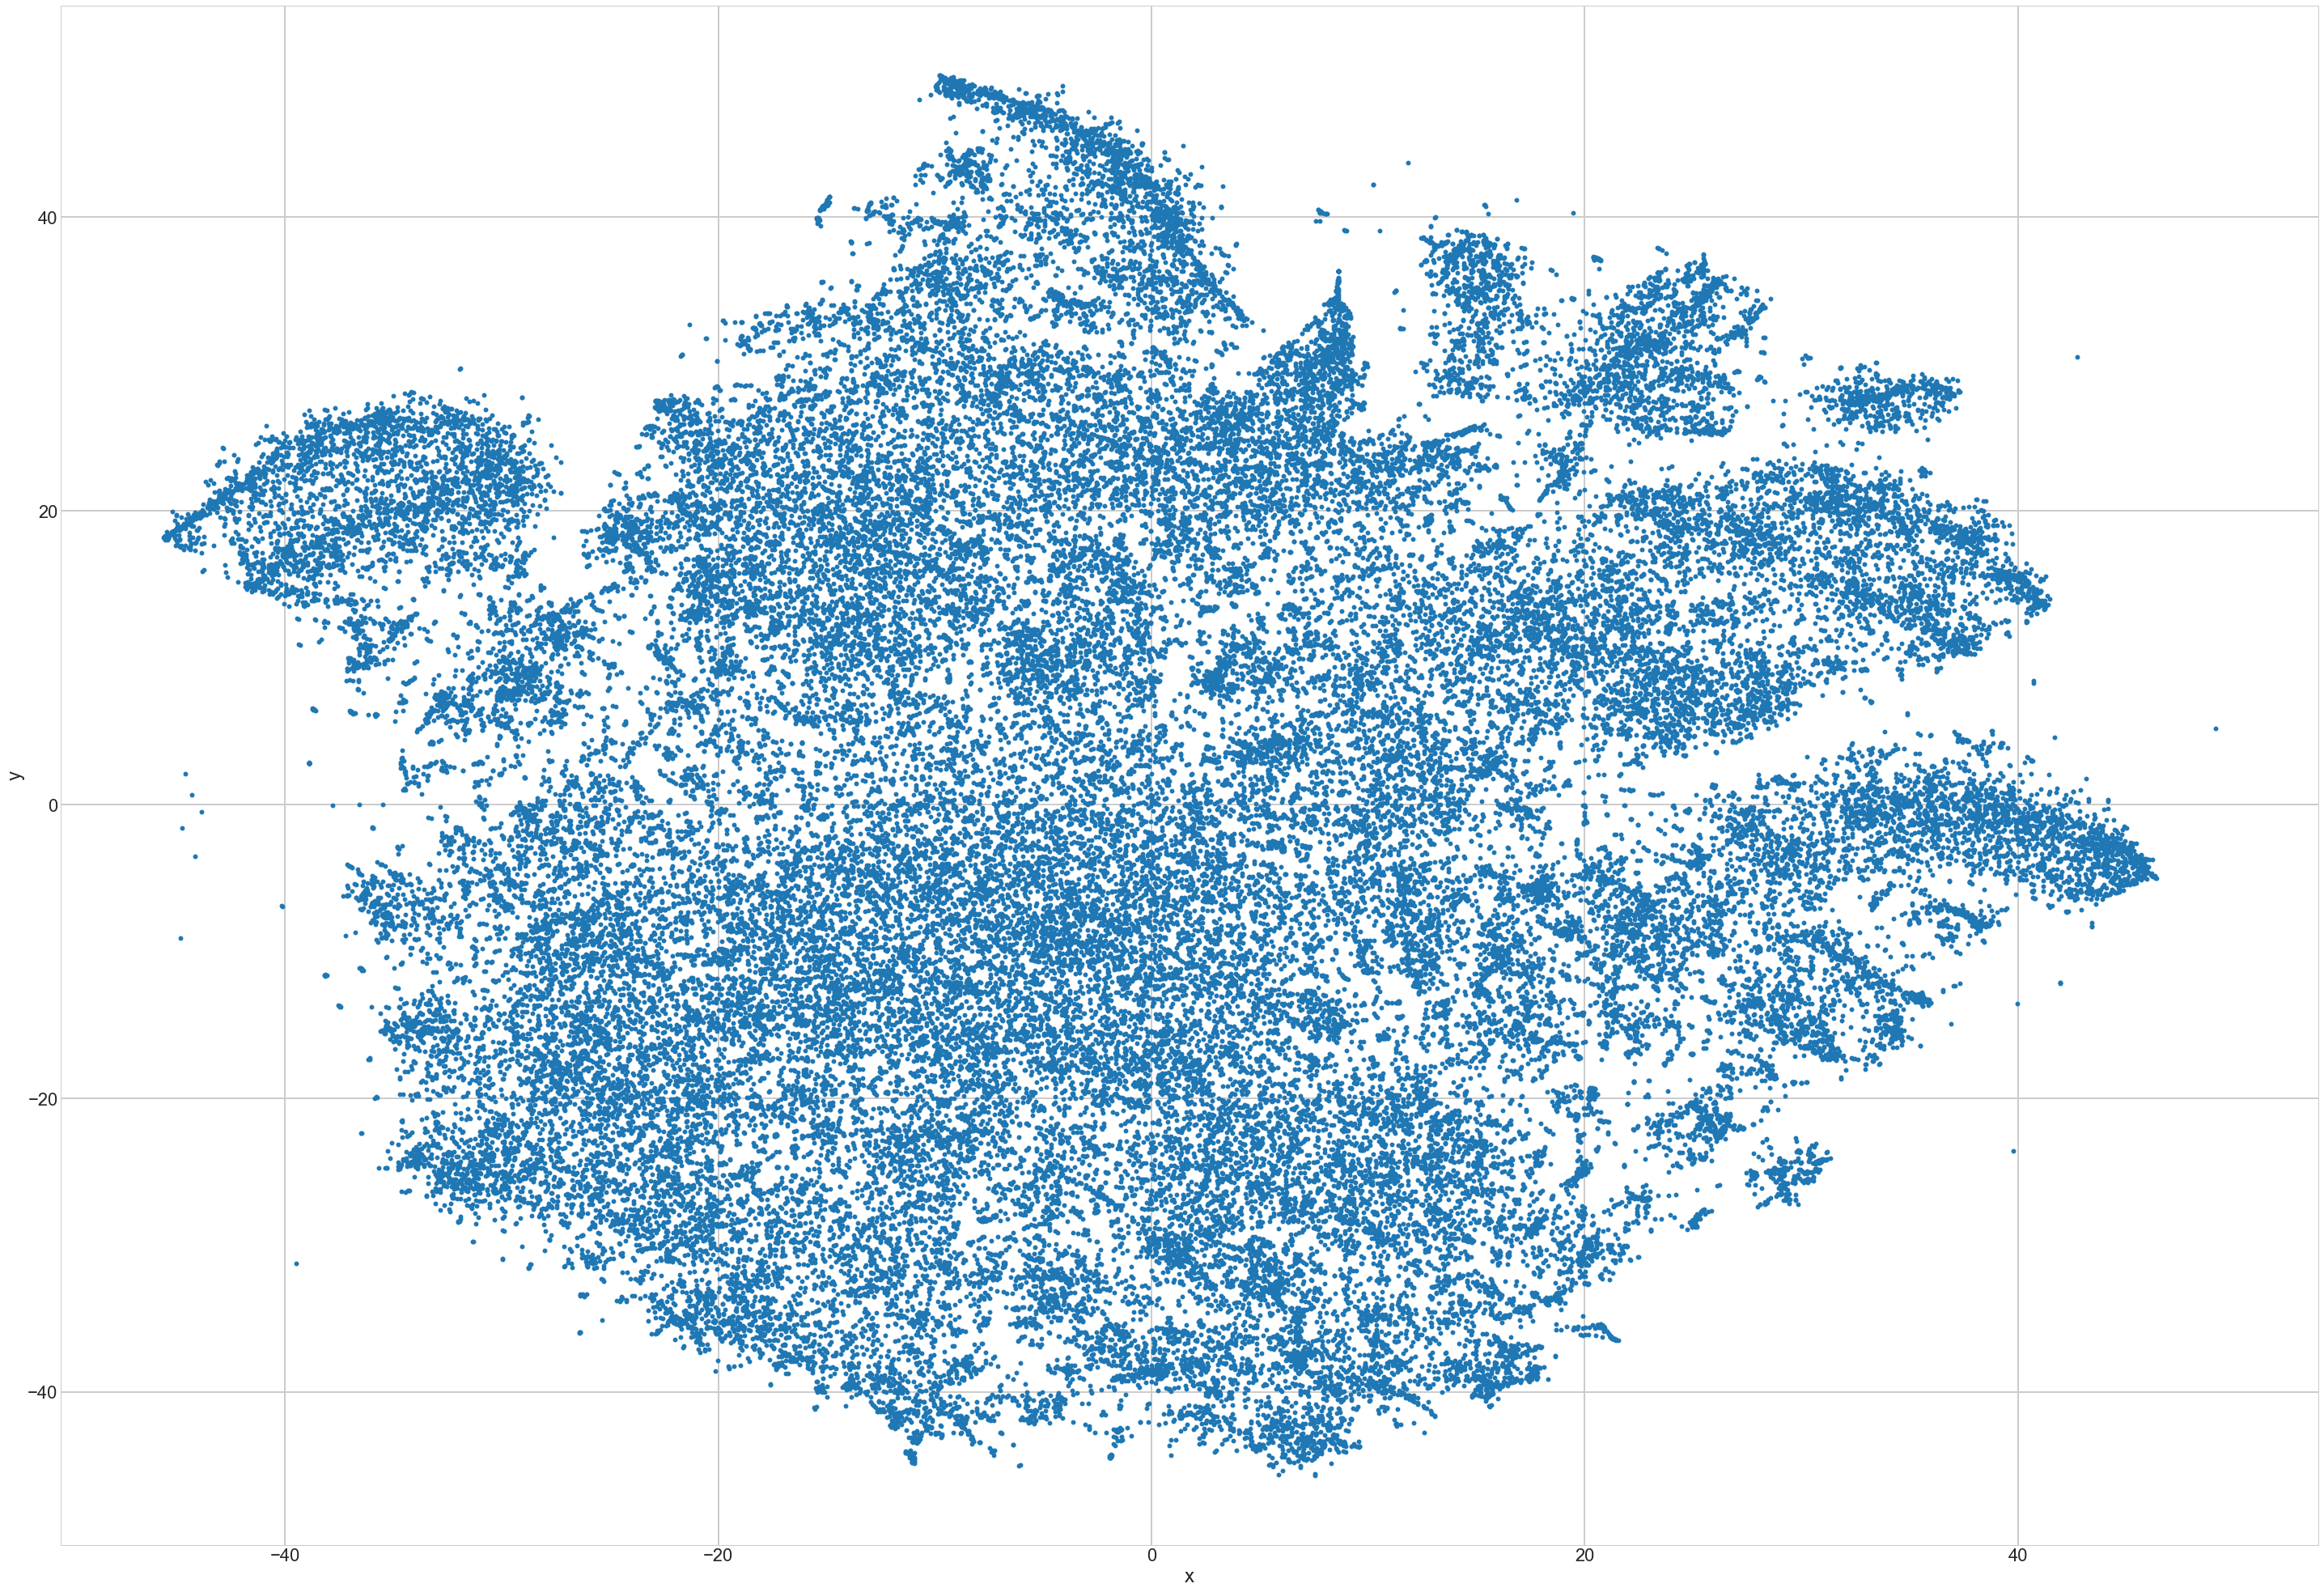

In [196]:
points.plot.scatter("x", "y", s=15, figsize=(50, 35))

Original code for plotting text. Faster to process but low readibility.

In [119]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20,12))
    for i, point in slice.iterrows():
        ax.text(point.x - 0.30, point.y + 0.15, point.word, fontsize=10)

In [ ]:
plot_region(x_bounds=(-20.0, 20.0), y_bounds=(-20.0, 20.0))

#### Make plot with adjusted text

It takes a loonger time, but is nicely ordered

In [195]:
from adjustText import adjust_text
sns.set_context("poster")
plt.style.use('seaborn-whitegrid')

In [14]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(30,20))
    texts = [ax.text(point.x, point.y, point.word, fontsize=10) for i, point in slice.iterrows()]
    adjust_text(texts) #arrowprops=dict(arrowstyle='->', color='gray')

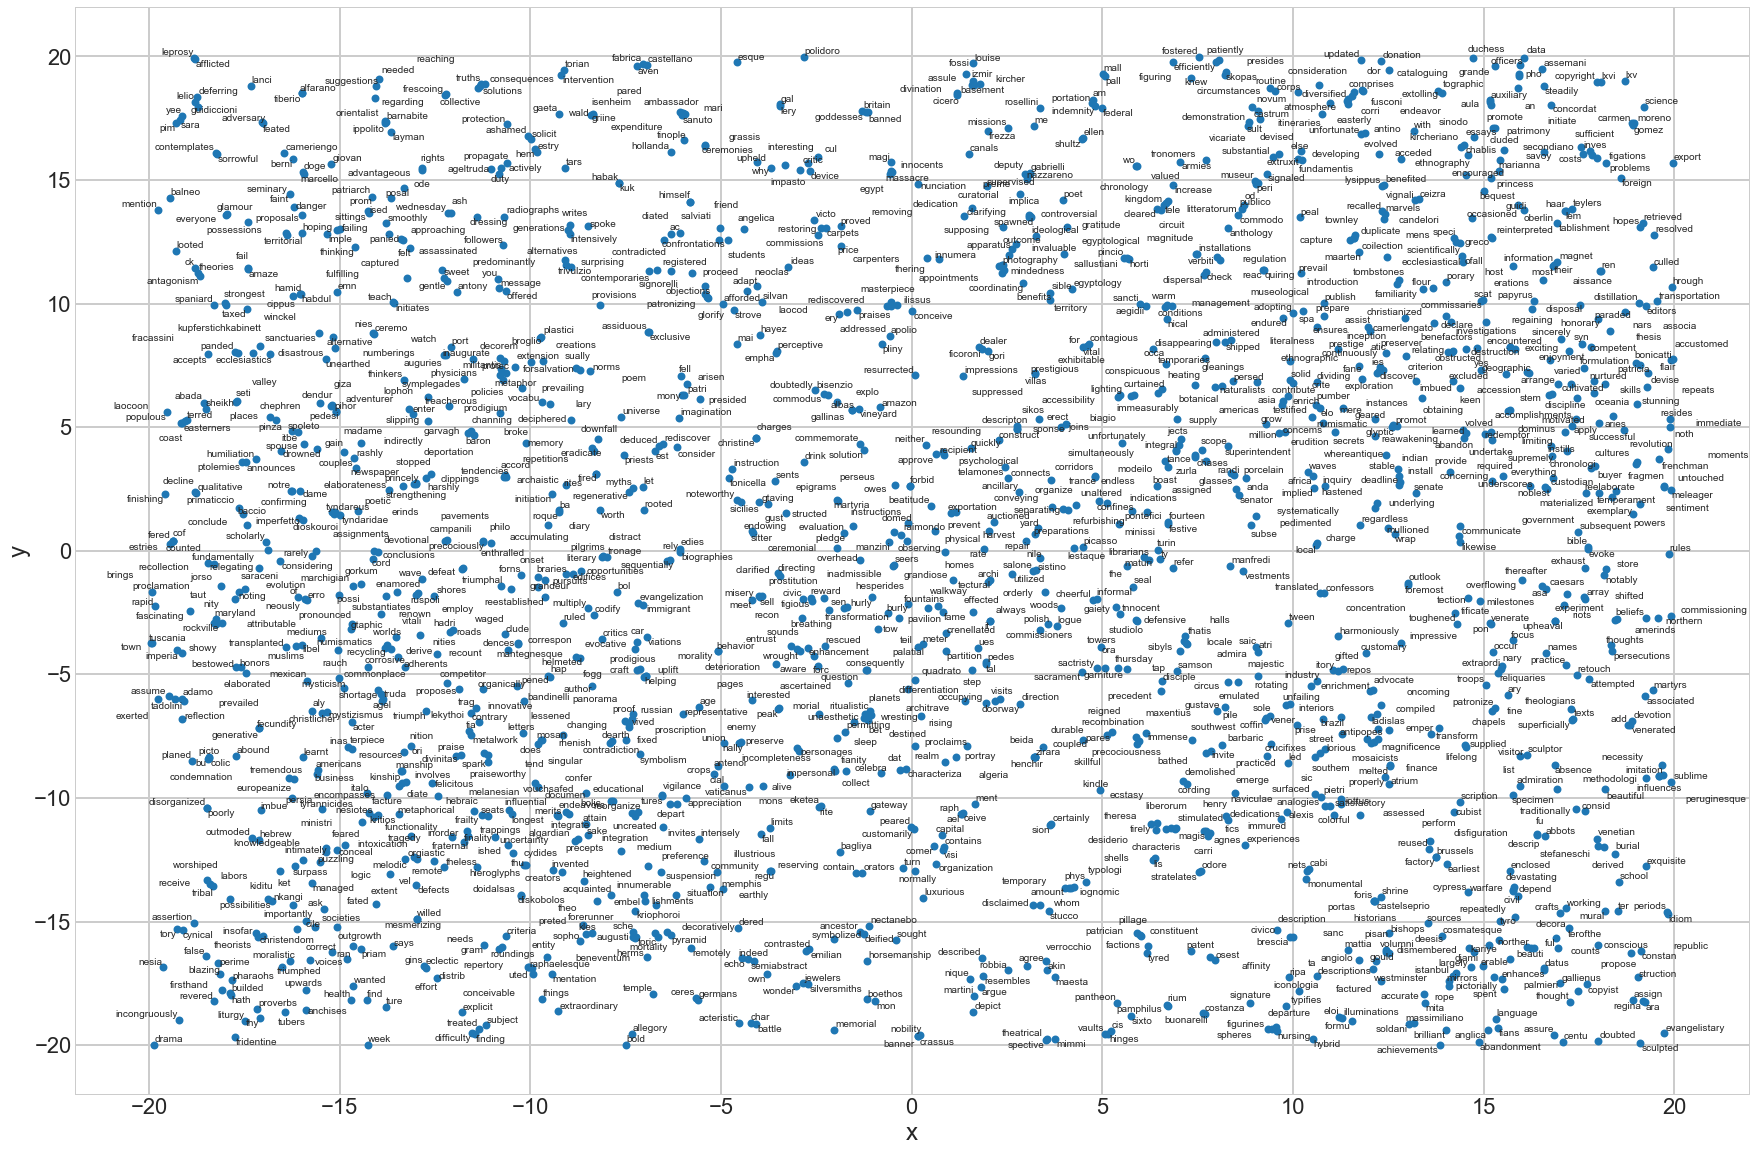

In [15]:
plot_region(x_bounds=(-20.0, 20.0), y_bounds=(-20.0, 20.0))

### Plotly interactive plotting

Instead of returning a png file within this notebook file, it returns a new window in browser that allows for zooming in, panning and so forth.

In [197]:
import plotly.graph_objs as go
import plotly.offline as pyo
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Higher quality but slow plot, opens in new window

In [3]:
pyo.plot([
    go.Scatter(
    x = points.x,
    y = points.y, 
    text = points.word,
    mode = 'markers+text',
    textposition='bottom center',
    textfont=dict(
        size=8,
        color='#494141'
    ),
    )   
])

Lower quality but fast plot, opens in new window

In [198]:
pyo.plot([
    go.Scattergl(
    x = points.x,
    y = points.y, 
    text = points.word,
    mode = 'markers+text',
    marker = dict(color = '#FFBAD2', line = dict(width = 1)),
    textfont=dict(size=8,color='#494141'),
    textposition='bottom center',
)])    

'temp-plot.html'

## Visualize a list of related words instead of all the plot

In [7]:
semantically_similar_words = {words: [item[0] for item in Meth2vec.wv.most_similar([words], topn=20)]
                  for words in ['figure', 'nude','portrait','woman','man']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

figure:['nude', 'figures', 'torso', 'putto', 'midas', 'foreshortened', 'threequarter', 'pose', 'crawling', 'mourner', 'contrapposto', 'verrocchiesque', 'unclothed', 'counterpart', 'doodle', 'pentimento', 'striding', 'reclining', 'meditating', 'standing']
nude:['reclining', 'crawling', 'screaming', 'helmeted', 'threequarter', 'midas', 'seminude', 'striding', 'turbaned', 'crayfish', 'satyress', 'conversing', 'emaciated', 'nudes', 'bellona', 'doodle', 'leaning', 'leering', 'halflength', 'pygmalion']
portrait:['portraits', 'likeness', 'mademoiselle', 'haussonville', 'madame', 'sitter', 'moitessier', 'stuart', 'monsieur', 'houdon', 'riviere', 'selfportrait', 'duvaucey', 'lethiere', 'hayard', 'desmarets', 'bartolini', 'cordier', 'composer', 'comtesse']
woman:['girl', 'boy', 'mandolin', 'tricorn', 'man', 'young', 'laughing', 'smiling', 'pregnant', 'gleaning', 'elderly', 'homan', 'threequarter', 'eggs', 'combing', 'crayfish', 'cowled', 'beetling', 'maid', 'israelite']
man:['woman', 'boy', 'bea

In [4]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

### Keyword visualization using PCA

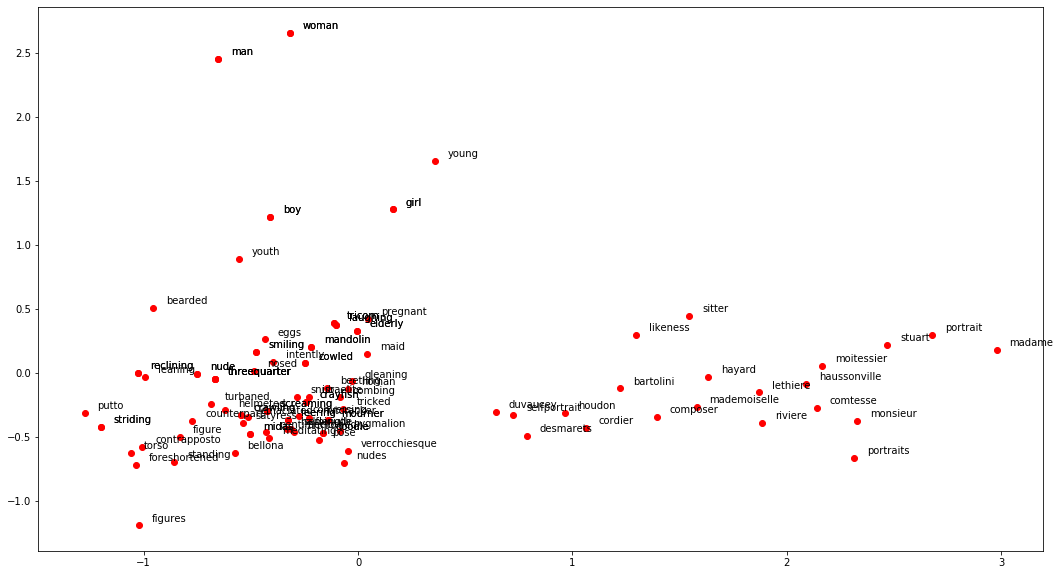

In [10]:
word_vectors = Meth2vec.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')


for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt # Matplotlib 2.0 shown here
from adjustText import adjust_text
import numpy as np
import pandas as pd

This cells adjust the font

In [171]:
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 11}

plt.rc('font', **font)

##In case yo need to go back to normal style run:
#plt.style.use('default')

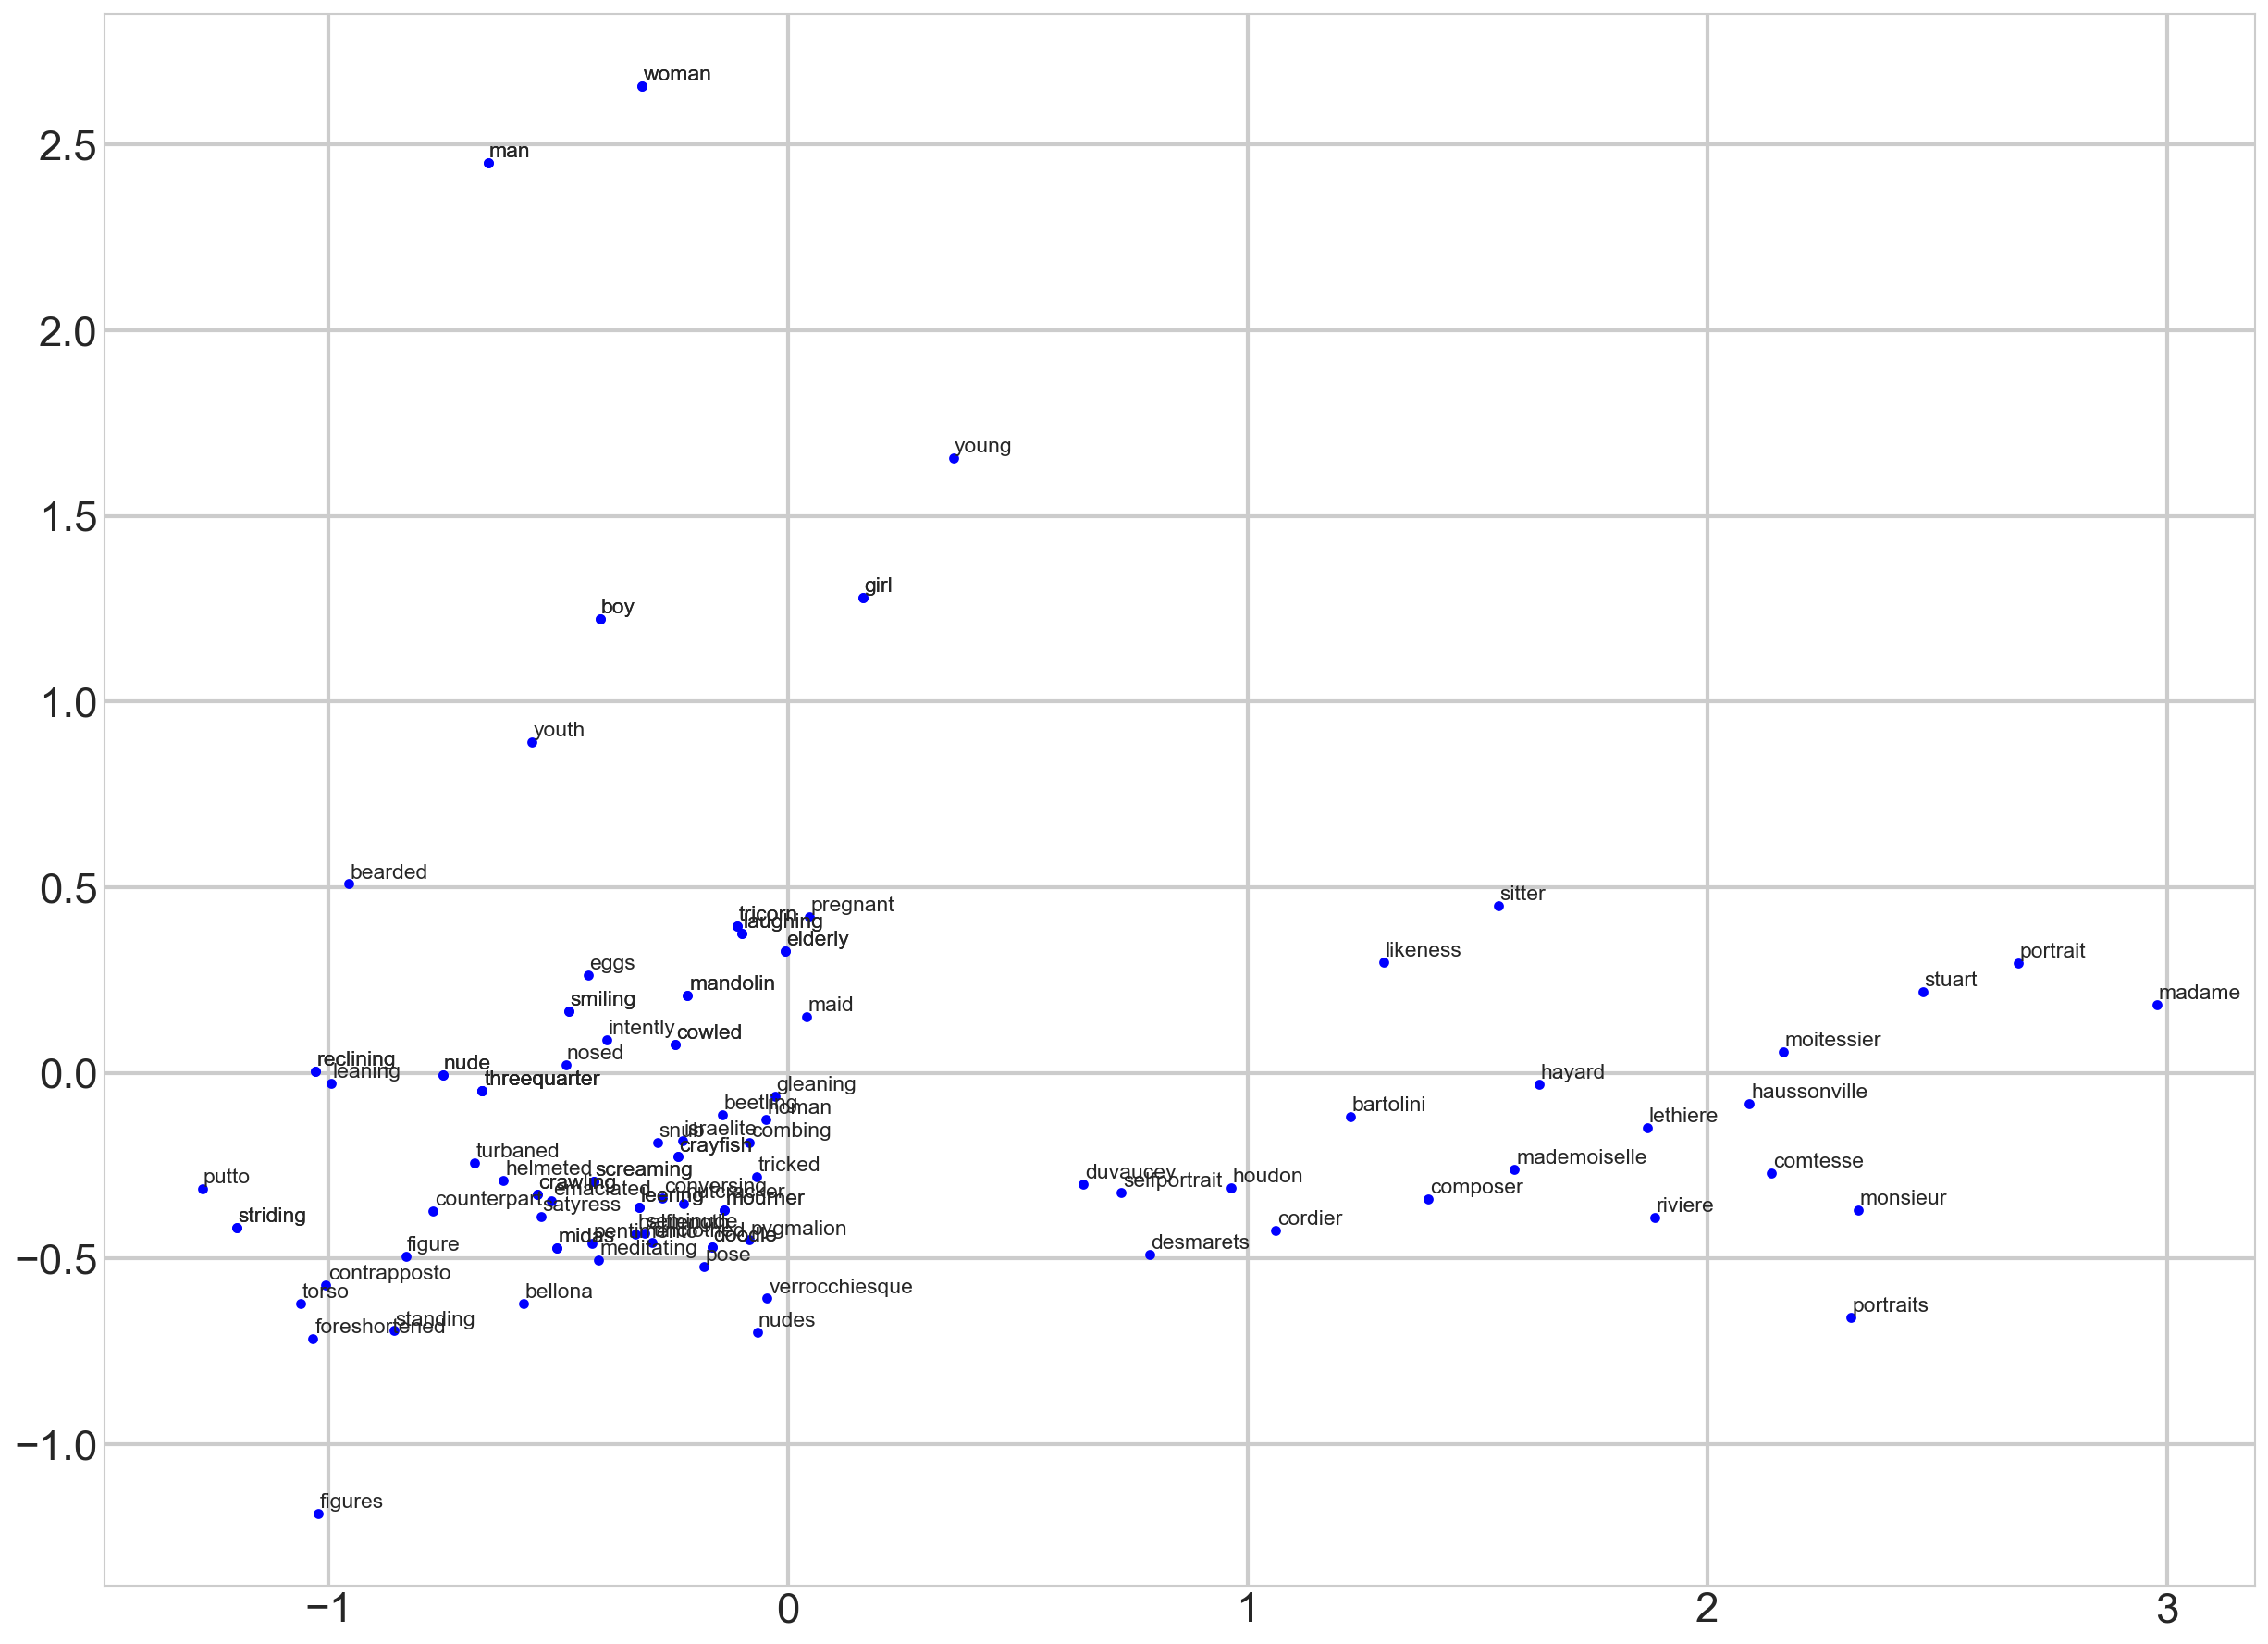

In [172]:
plt.figure(figsize=(20, 15), dpi=150)
plt.scatter(p_comps[:, 0], p_comps[:, 1], s=10, c='blue')

for word_names, x, y in zip(all_similar_words, p_comps[:, 0], p_comps[:, 1]):
    plt.plot(x, y)
    texts = [plt.text(x, y, word_names)]
    adjust_text(texts)

### Keyword visualization using T-sne

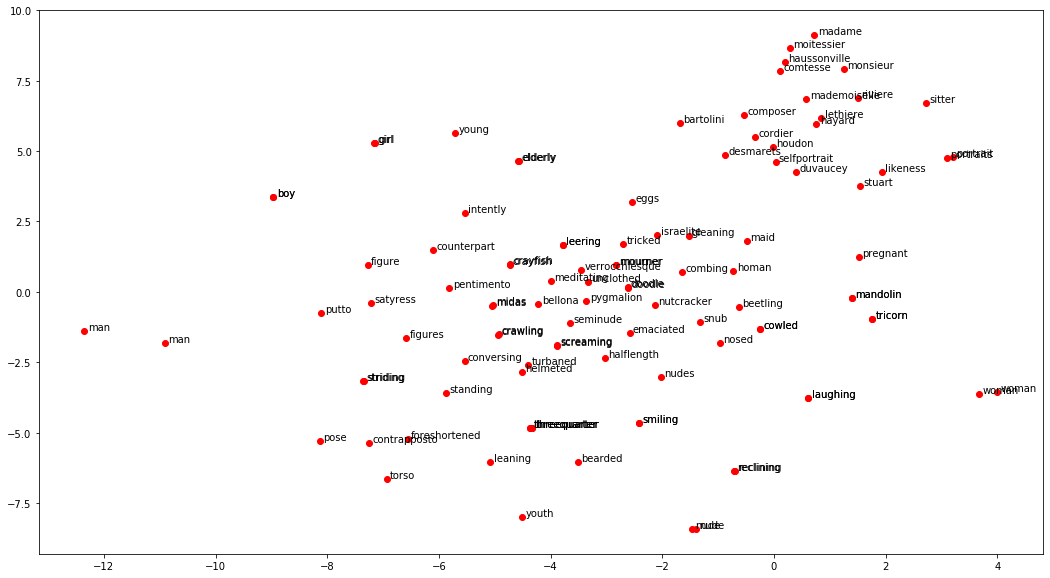

In [19]:
word_vectorz = Meth2vec.wv[all_similar_words]

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

t_comps = tsne.fit_transform(word_vectorz)
word_namez = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(t_comps[:, 0], t_comps[:, 1], c='red')


for word_namez, x, y in zip(word_namez, t_comps[:, 0], t_comps[:, 1]):
    plt.annotate(word_namez, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

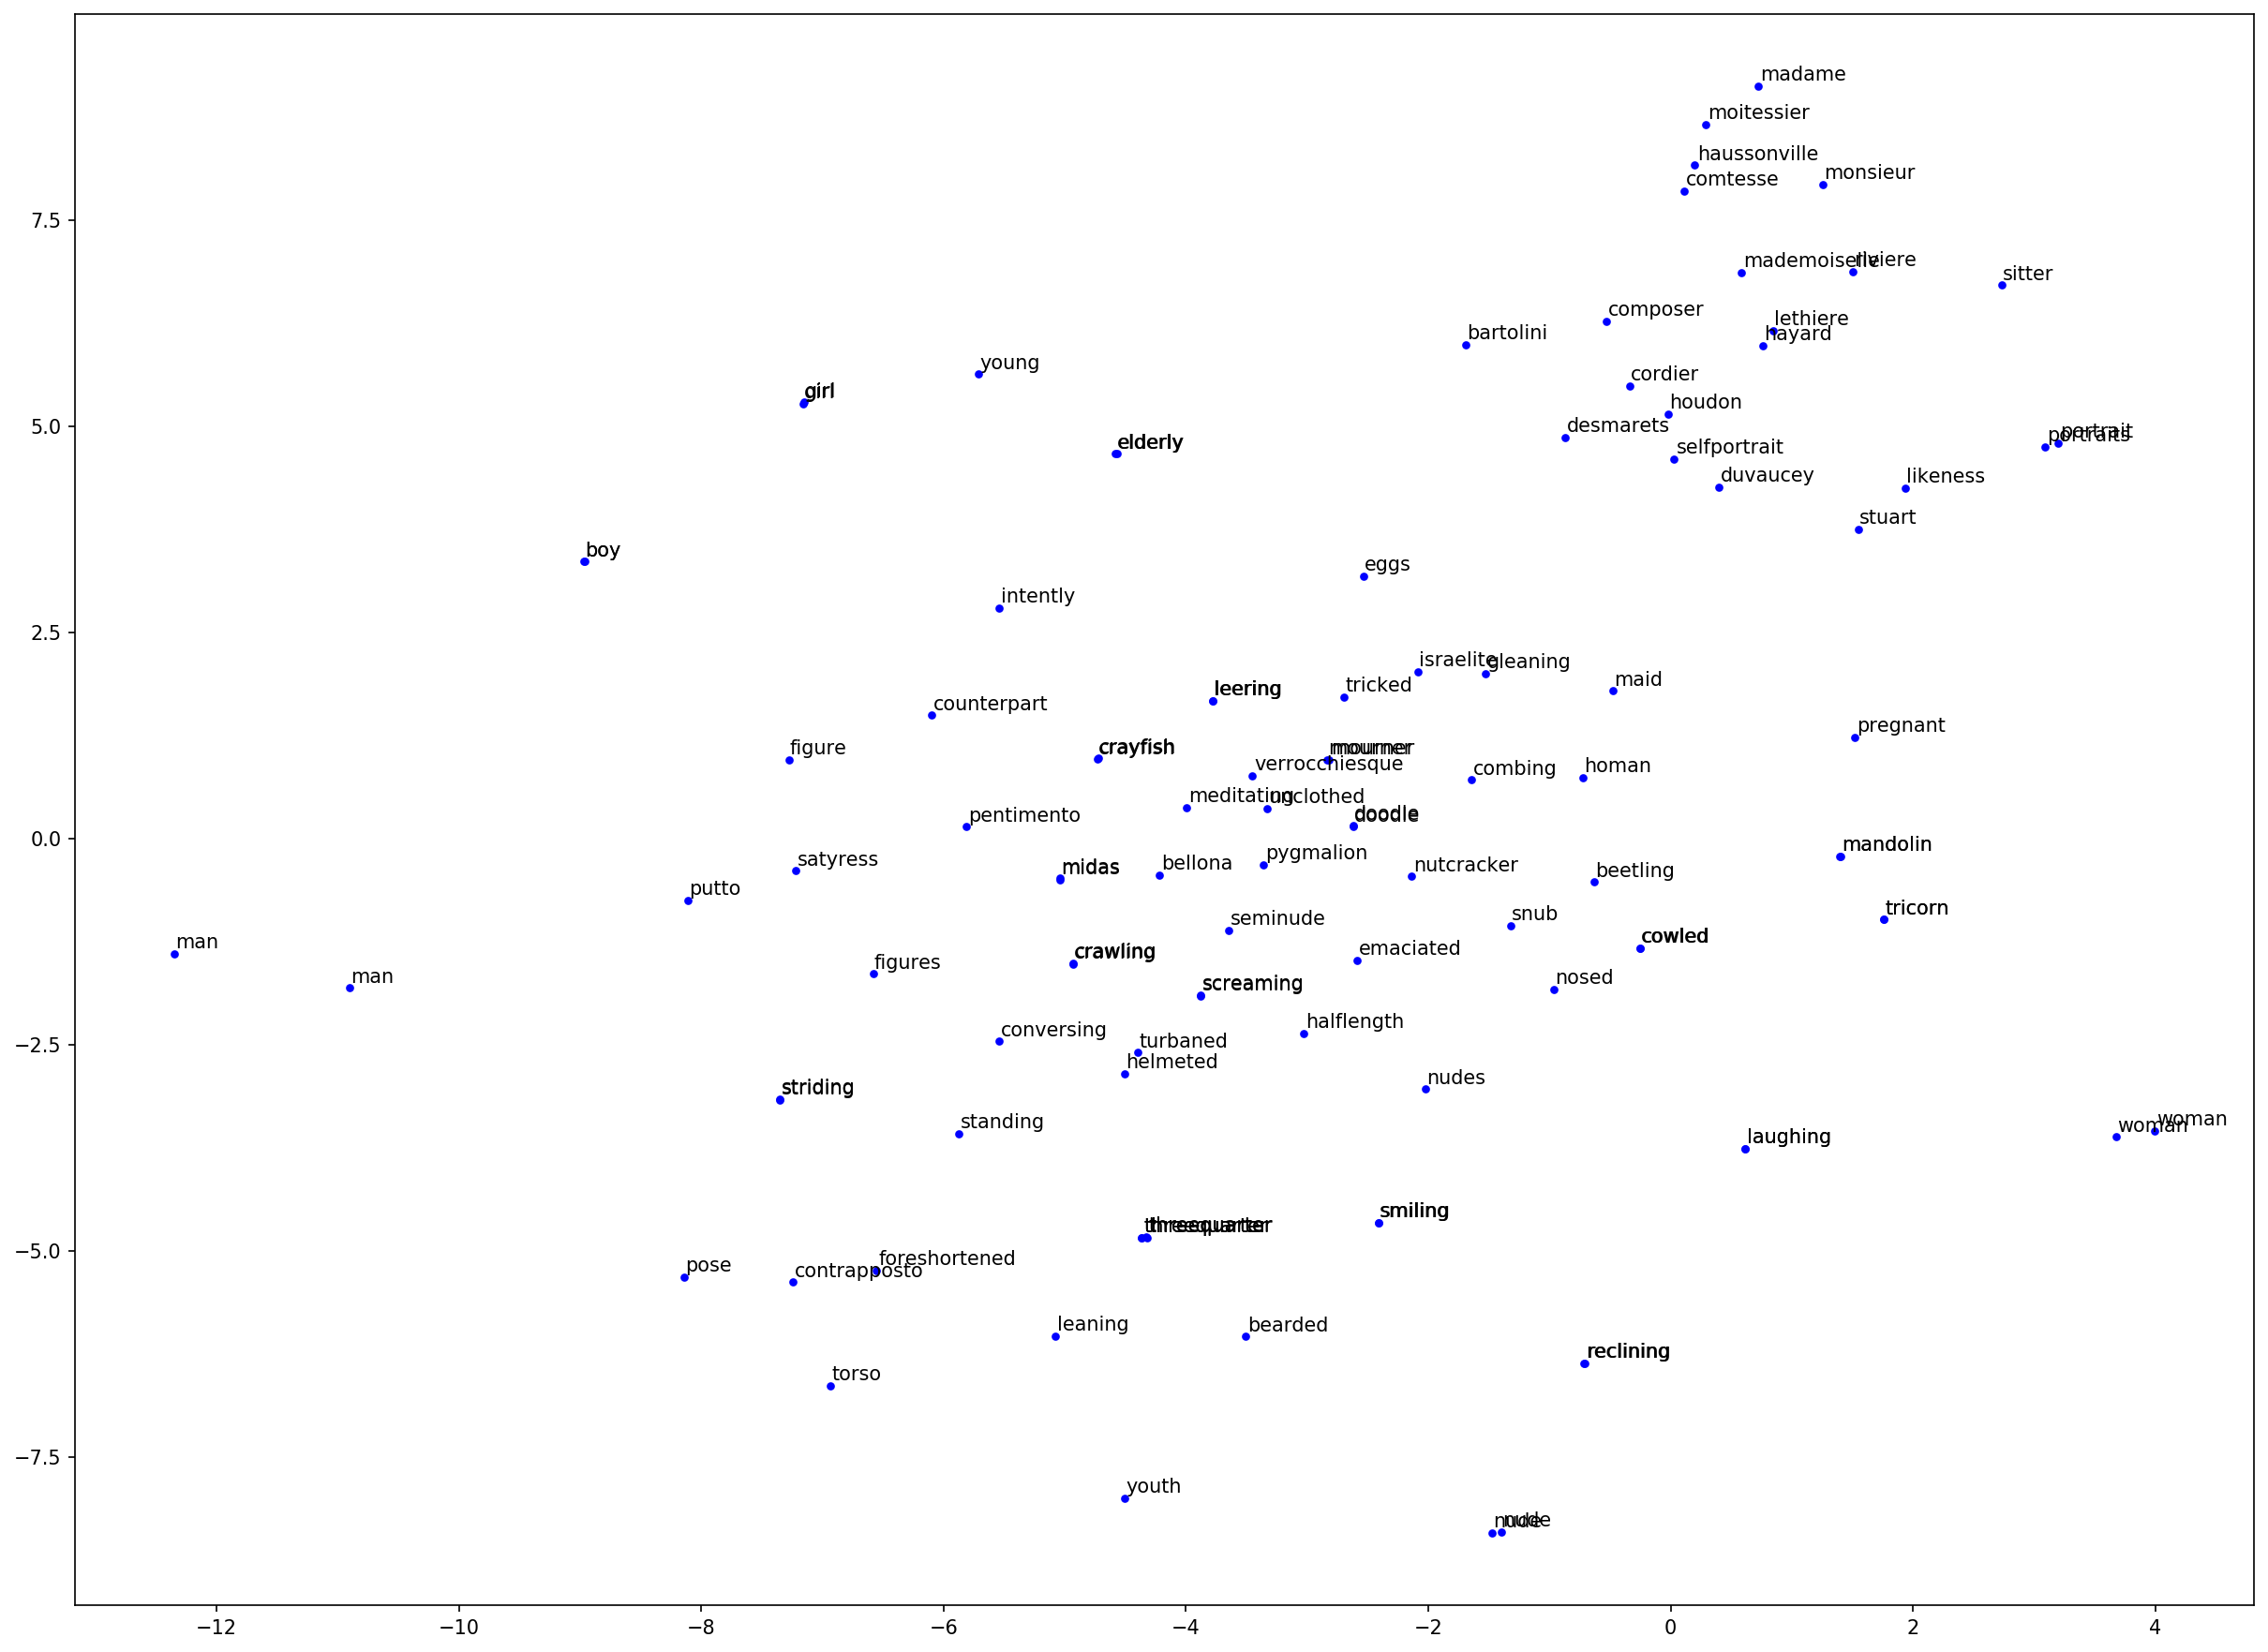

In [16]:
plt.figure(figsize=(20, 15), dpi=150)
plt.scatter(t_comps[:, 0], t_comps[:, 1], s=10, c='blue')

for word_names, x, y in zip(all_similar_words, t_comps[:, 0], t_comps[:, 1]):
    plt.plot(x, y)
    texts = [plt.text(x, y, word_names)]
    adjust_text(texts)

## Word Simmilarity lookup

In [26]:
Meth2vec.wv.most_similar("artist",topn=30)

[('nude', 0.57099449634552),
 ('figures', 0.5477038025856018),
 ('torso', 0.5433209538459778),
 ('putto', 0.5426357984542847),
 ('midas', 0.5360404253005981),
 ('foreshortened', 0.5359063744544983),
 ('threequarter', 0.5338197946548462),
 ('pose', 0.5281904339790344),
 ('crawling', 0.5273319482803345),
 ('mourner', 0.5266833305358887),
 ('contrapposto', 0.5222638845443726),
 ('verrocchiesque', 0.5214159488677979),
 ('unclothed', 0.5183730721473694),
 ('counterpart', 0.518208384513855),
 ('doodle', 0.5150623321533203),
 ('pentimento', 0.5140149593353271),
 ('striding', 0.5136651396751404),
 ('reclining', 0.5134265422821045),
 ('meditating', 0.5127214193344116),
 ('standing', 0.5113130807876587),
 ('seated', 0.5096101760864258),
 ('seminude', 0.5093531608581543),
 ('reprise', 0.5072249174118042),
 ('yogic', 0.507135272026062),
 ('muscularity', 0.5060216188430786),
 ('doleful', 0.5030638575553894),
 ('dantesque', 0.502665102481842),
 ('genitals', 0.5024797320365906),
 ('frontally', 0.5021

In [23]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = Meth2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [26]:
nearest_similarity_cosmul("aesthetic", "art", "male")


aesthetic is related to art, as gender is related to male


'gender'

*Analysis*

Some similarity results between words are as interesting (or more) than some of the highly ranked keywords by tf-idf. Therefore, to build the categories on which to train the transfer learning NN, I propose to go through the not-noisy terms and replace some noisy terms, or other non-interesting terms manually. This is indeed, absolutely to the criteria of the curator to make this choice of words, but in order to have terms that are both meaningful from quantity and quality, data-representative and affective at the same time, is necessary to take this approach. Therefore, I advocate for this collab in the build up of a better category list.